In [246]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Set custom styles for text color
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'  # Color of the x-axis tick values
plt.rcParams['ytick.color'] = 'white'  # Color of the y-axis tick values

# tensorflow
import tensorflow as tf
import tensorflow_decision_forests as tfdf 

# feature engineering
from sklearn.feature_selection import mutual_info_regression

# For local run
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# For kaggle run
# train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
# test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [247]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.shape

(1459, 2)

In [248]:
sample_submission.head()

Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570
3  1464  179317.477511
4  1465  150730.079977

In [249]:
# code for subplots
# data_num = data.select_dtypes(include=['int64', 'float64'])
# data_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

In [250]:
target = train.columns.to_list()[-1]
train_target = train[target]
train_target_log = np.log1p(train_target)

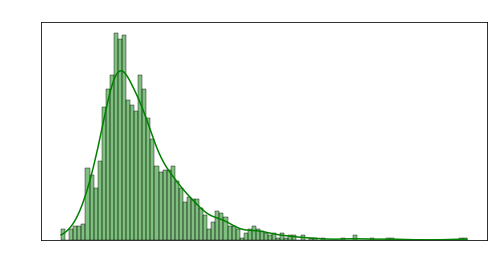

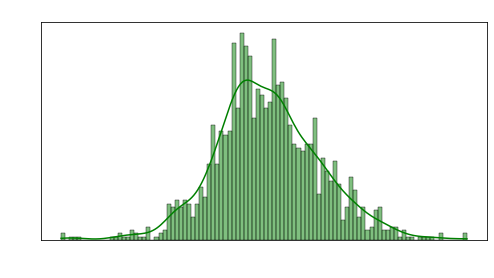

In [251]:
# normalization helps cause sale price is a bit skewed
plt.figure(figsize=(8,4))
sns.histplot(train_target, color='g', bins=100, kde=True)
plt.title('Original')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(train_target_log, color='g', bins=100, kde=True)
plt.title('Log')
plt.show()

In [252]:
train_target = train_target_log
train.drop(target, axis=1, inplace=True)
train_id = train['Id']
test_id = test['Id']
# cause Ids shouldn't go in model
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
random_seed = 1

# since feature engineering should be on both
combined = pd.concat([train, test], axis=0)

### Feature engineering

In [253]:
cat_handle = 1
num_handle = 1

if cat_handle == 1:
    cat_handle = 'FillWithMedian'
else:
    cat_handle = 'GetDummies'
    
if num_handle == 1:
    num_handle = 'log1p'
else:
    num_handle = 'BoxCox'

In [254]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

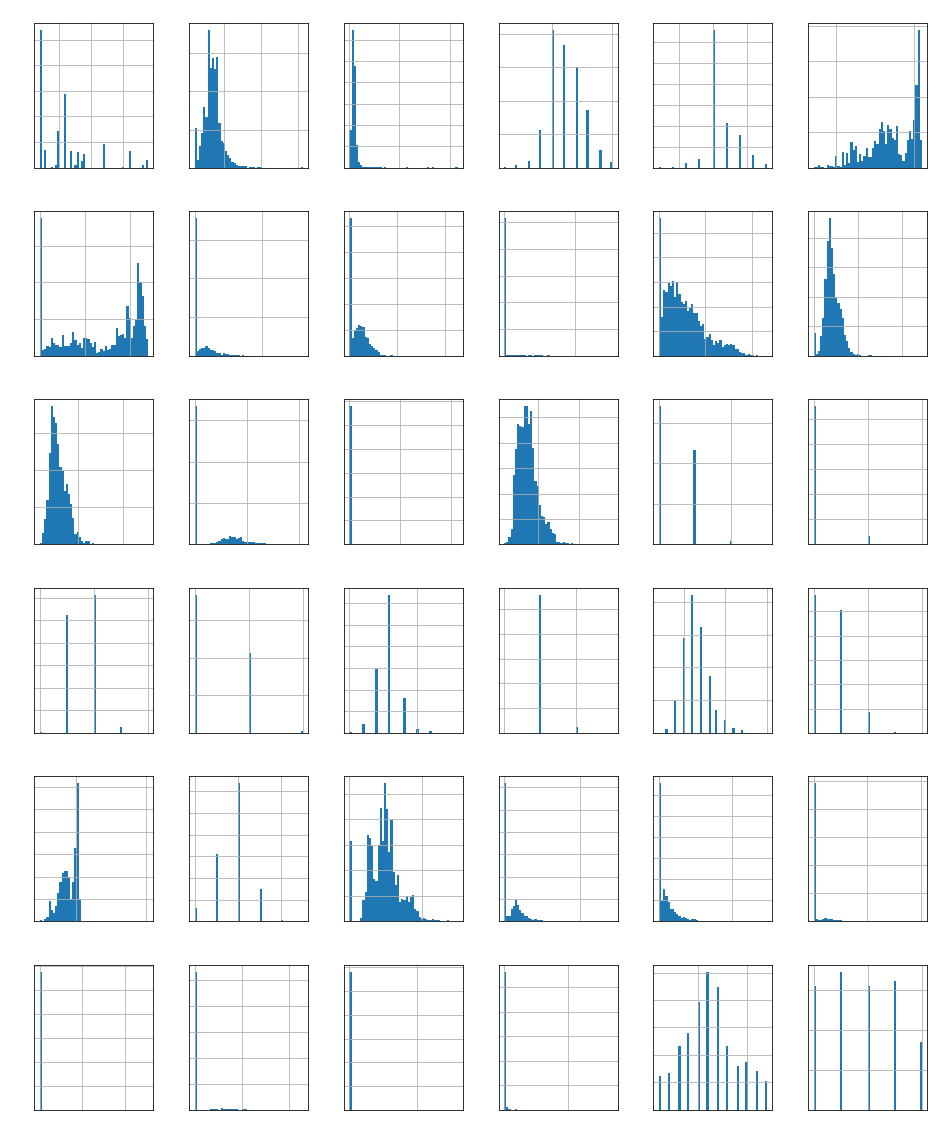

In [255]:
data_num = combined.select_dtypes(include=['int64', 'float64'])
data_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

In [256]:
# MSSubClass is cateogorical not numerical
combined['MSSubClass'] = combined['MSSubClass'].astype('object')
combined['MoSold'] = combined['MoSold'].astype('object')

In [257]:
# Ordinal features, features that have a ranking
# Convert these to numerical, cause then there is comparison rather than grouping



In [258]:
col_ord = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
          'GarageQual', 'GarageCond', 'PoolQC', 'FireplaceQu']
print('Unique values', combined[col_ord].stack().unique())

for col in col_ord:
    combined[col] = combined[col].map({np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
    
# interesting, how would you get these labels without knowing their meaning
# combined['BsmtFinType1'] = combined['BsmtFinType1'].map({np.nan: 0, 'Unf': 5, 'LwQ': 2, 
#                                                          'BLQ': 1, 'Rec': 3,
#                                                          'ALQ': 4, 'GLQ': 6})

Unique values ['Gd' 'TA' 'Ex' 'Fa' 'Po']


<AxesSubplot:xlabel='BsmtFinType2', ylabel='SalePrice'>

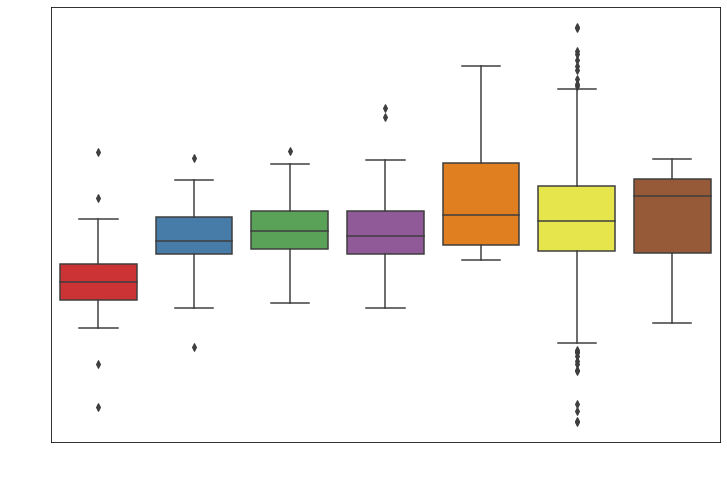

In [264]:
col = 'BsmtFinType2'
X = combined[:train_id.shape[0]][[col]]
# hmm this is interesting, should the map be based on ordinal ranking
# or the quality of price based on the category
X[col] = X[col].map({np.nan: 0, 'Unf': 5, 'LwQ': 2, 'BLQ': 1, 'Rec': 3,
                             'ALQ': 4, 'GLQ': 6})
X['SalePrice'] = train_target

plt.figure(figsize=(12,8))
sns.boxplot(x=col, y="SalePrice", palette="Set1", data=X)

In [194]:
print(combined['BsmtFinType1'].unique())
print(combined['BsmtFinType2'].unique())
print(combined['Functional'].unique())
print(combined['Fence'].unique())
print(combined['BsmtExposure'].unique())
print(combined['Fence'].unique())

['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev' nan]
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
['No' 'Gd' 'Mn' 'Av' nan]
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


1. Lot Area

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Text(0.5, 1.0, 'LotArea')

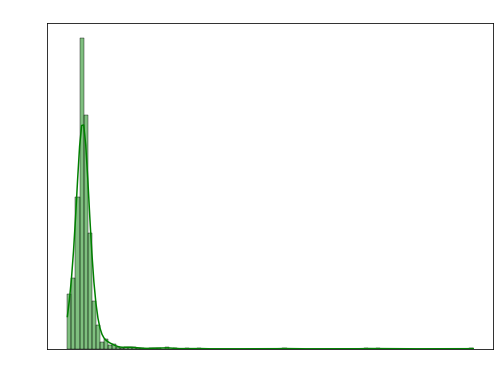

In [97]:
series = data['LotArea']
display(series.describe())

plt.figure(figsize=(8,6))
sns.histplot(series, color='g', bins=100, kde=True)
plt.title('LotArea')

count    1460.000000
mean        9.110838
std         0.517448
min         7.170120
25%         8.929766
50%         9.156781
75%         9.358890
max        12.279532
Name: LotArea, dtype: float64

Text(0.5, 1.0, 'LotArea (log)')

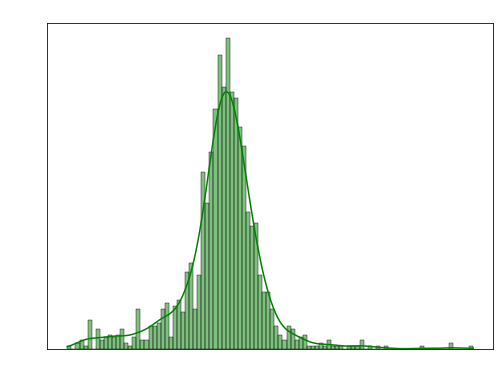

In [98]:
# taking log seems to help a lot!
series = np.log(data['LotArea'])
display(series.describe())

plt.figure(figsize=(8,6))
sns.histplot(series, color='g', bins=100, kde=True)
plt.title('LotArea (log)')

2. MasVnrType/Area: structural support type i guess

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

<AxesSubplot:xlabel='MasVnrArea', ylabel='Count'>

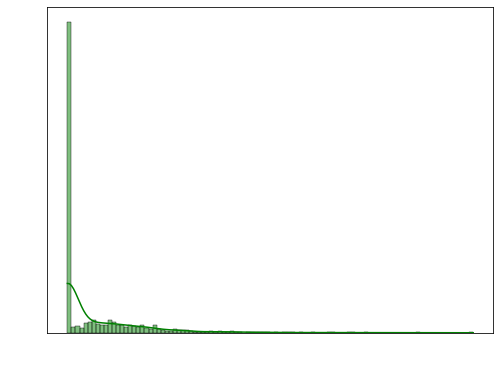

In [99]:
series = data['MasVnrArea']
display(series.describe())

plt.figure(figsize=(8,6))
sns.histplot(series, color='g', bins=100, kde=True)

count    1452.000000
mean      -11.525914
std        13.896448
min       -23.025851
25%       -23.025851
50%       -23.025851
75%         5.111988
max         7.377759
Name: MasVnrArea, dtype: float64

<AxesSubplot:xlabel='MasVnrArea', ylabel='Count'>

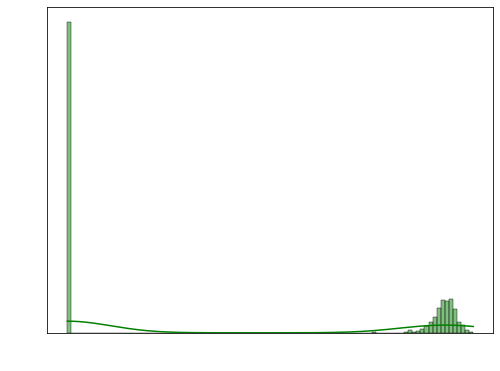

In [100]:
# cause can't take log of 0, so added a constant, but ehhh doesn't change the story
small_constant = 1e-10
series = np.log(data['MasVnrArea'] + small_constant)
display(series.describe())

plt.figure(figsize=(8,6))
sns.histplot(series, color='g', bins=100, kde=True)

In [101]:
series = data['MasVnrType']
series.fillna('None', inplace=True)
vals, freq = np.unique(series, return_counts=True)
list(zip(vals, freq))

[('BrkCmn', 15), ('BrkFace', 445), ('None', 872), ('Stone', 128)]

/Users/mony/opt/anaconda3/envs/zero/lib/python3.9/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


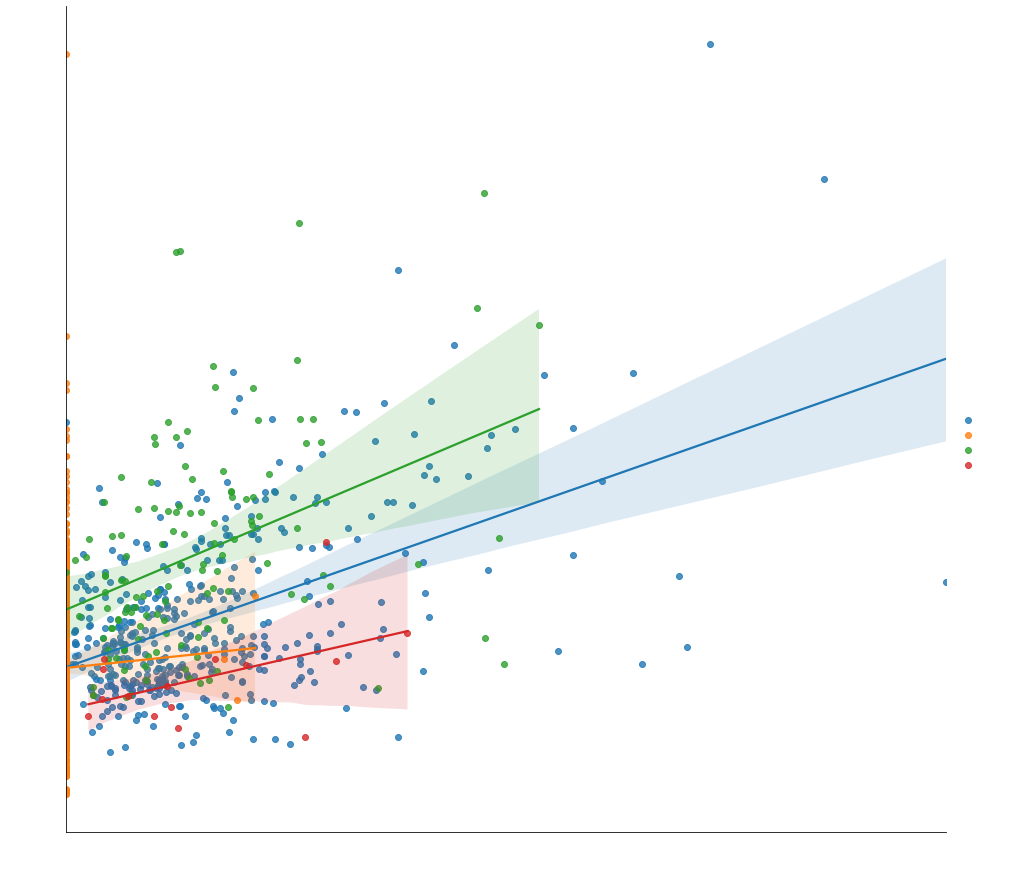

In [102]:
df = data[['MasVnrType', 'MasVnrArea', 'SalePrice']]
df['MasVnrType'].fillna('None', inplace=True)

sns.lmplot(x='MasVnrArea', y='SalePrice', hue="MasVnrType", data=df,
          height=12, aspect=1.1)

Hmm looks like some relationship exists, but worth keeping both variables? especially with so many empty values...increased area represents higher price, and category seem to help too actually. let's leave as it is. Though, fill 'None' for nan in categorical variable

3. Basement

In [103]:
df = data[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
          'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'SalePrice']]
df.head()

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
0       Gd       TA           No          GLQ         706          Unf   
1       Gd       TA           Gd          ALQ         978          Unf   
2       Gd       TA           Mn          GLQ         486          Unf   
3       TA       Gd           No          ALQ         216          Unf   
4       Gd       TA           Av          GLQ         655          Unf   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  SalePrice  
0           0        150          856     208500  
1           0        284         1262     181500  
2           0        434          920     223500  
3           0        540          756     140000  
4           0        490         1145     250000

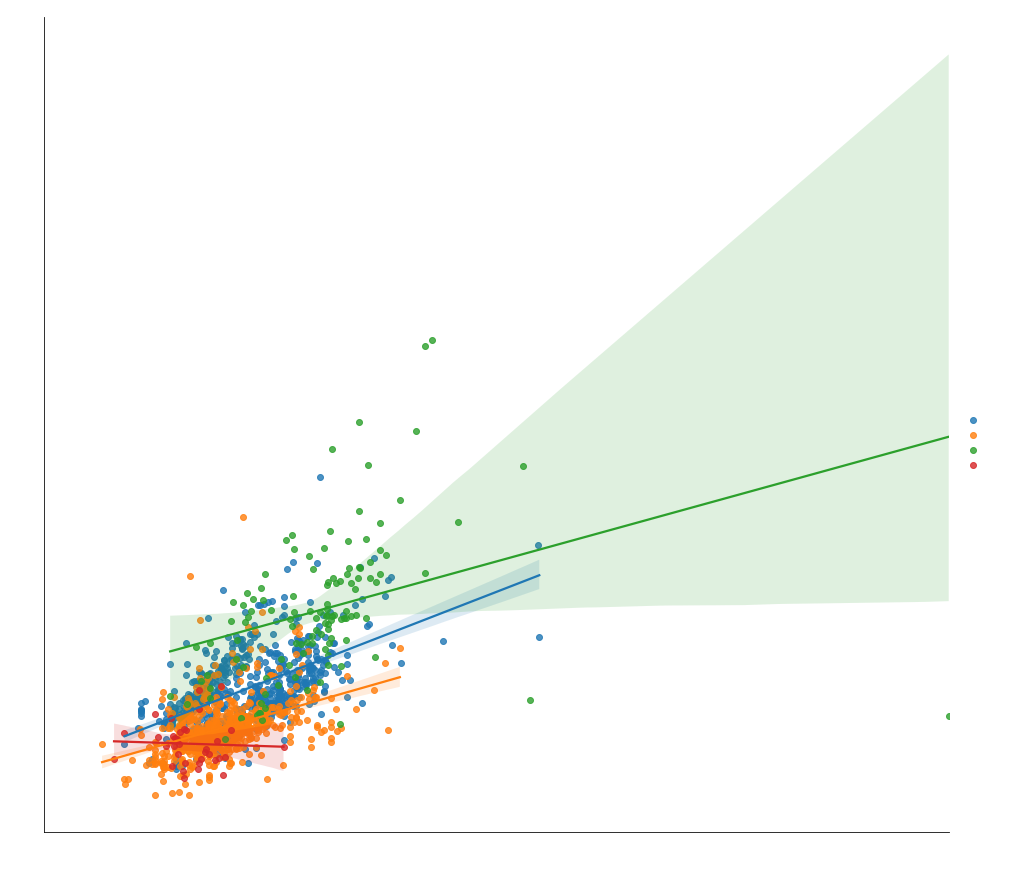

In [104]:
sns.lmplot(x='TotalBsmtSF', y='SalePrice', hue='BsmtQual', data = df, height=12, aspect=1.1)

### Data preparation

In [9]:
label = 'SalePrice'
data.drop('Id', axis=1, inplace=True) # don't need the key

In [10]:
data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [11]:
data.shape

(1460, 80)

In [12]:
def train_test_split(data, test_ratio = 0.3):
    test_indices = np.random.rand(len(data)) < test_ratio
    return data[~test_indices], data[test_indices]

train_data, test_data = train_test_split(data)
print('{} samples in training data, {} samples in testing data'.format(train_data.shape[0],
                                                                      test_data.shape[0]))

1031 samples in training data, 429 samples in testing data


In [13]:
# convert pandas to tensorflow datasets
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=label, 
                                      task=tfdf.keras.Task.REGRESSION)
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=label,
                                     task=tfdf.keras.Task.REGRESSION)

### Model: TFDF

In [14]:
rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics='mse')

Use /var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/tmprz8ucmm0 as temporary training directory


In [15]:
rf.fit(x=train_data)

Reading training dataset...
Training dataset read in 0:00:03.972429. Found 1031 examples.
Training model...


[INFO 23-08-27 09:59:06.3303 MDT kernel.cc:1243] Loading model from path /var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/tmprz8ucmm0/model/ with prefix 5c29c01fe0cf4839
[INFO 23-08-27 09:59:06.5179 MDT decision_forest.cc:660] Model loaded with 300 root(s), 98080 node(s), and 76 input feature(s).
[INFO 23-08-27 09:59:06.5179 MDT abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-08-27 09:59:06.5180 MDT kernel.cc:1075] Use fast generic engine


Model trained in 0:00:00.662020
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [33]:
tfdf.model_plotter.plot_model_in_colab(rf, max_depth=5, tree_idx=0)

In [17]:
logs = rf.make_inspector().training_logs()
display(logs)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=380, accuracy=None, loss=None, rmse=44461.6351320085, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=12, evaluation=Evaluation(num_examples=992, accuracy=None, loss=None, rmse=38732.891406739676, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=23, evaluation=Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=32524.385987196438, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=33, evaluation=Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=31590.893168659022, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=43, evaluation=Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=30963.913014659385, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=53, evaluation=Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=30956.447363521092, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=63, evaluatio

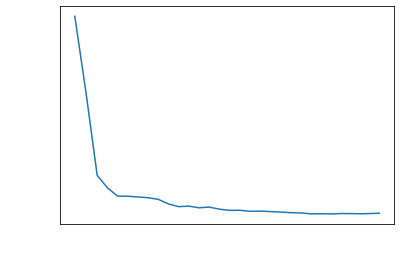

In [18]:
# OOB: Out of Bags, rf chooses random sample to train, so this helps to visualize the training accuracy
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.show()

In [19]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=29677.56910677615, ndcg=None, aucs=None, auuc=None, qini=None)

In [20]:
# let's evaluate using our testing set
evaluation = rf.evaluate(x=test_data, return_dict=True)
display(evaluation)

1/1 [==============================] - 0s 445ms/step - loss: 0.0000e+00 - mse: 1022212672.0000


{'loss': 0.0, 'mse': 1022212672.0}

### Variable importance

In [21]:
# num_as_root, which feature is best suited for root
# inv_mean_min_depth, helps understand how quickly each feature appreach in the tree
#      early it appears, more importance it is
# sum_score: how important is a feature contributing towards the end result
# num_nodes: total number of nodes in decision tree
inspector.variable_importances().keys()

dict_keys(['INV_MEAN_MIN_DEPTH', 'SUM_SCORE', 'NUM_AS_ROOT', 'NUM_NODES'])

In [22]:
inspector.variable_importances()['SUM_SCORE'][0:5]

[("OverallQual" (1; #62), 462715969500642.75),
 ("Neighborhood" (4; #59), 235062589496462.12),
 ("GrLivArea" (1; #38), 220995423710532.4),
 ("ExterQual" (4; #22), 143247601271221.62),
 ("GarageCars" (1; #32), 107173743364614.0)]

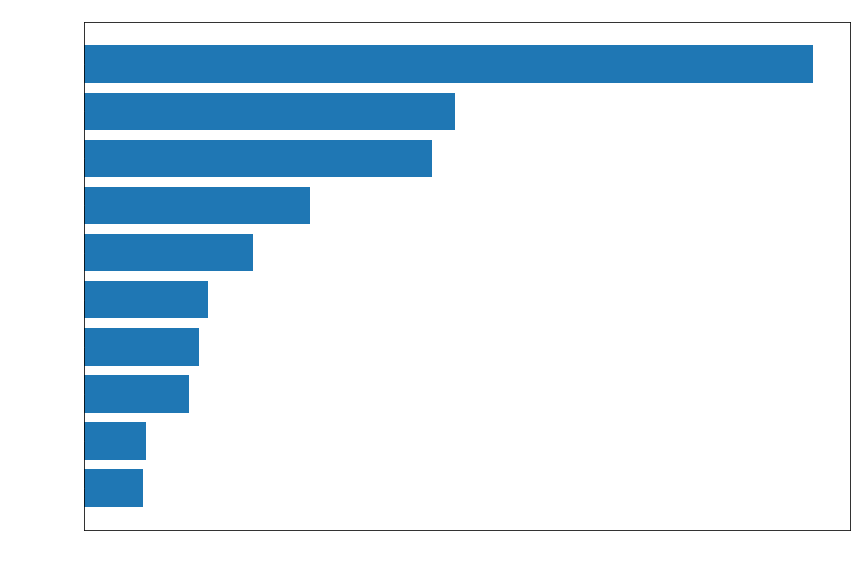

In [23]:
plt.figure(figsize=(12,8))

var_importance_metric = 'SUM_SCORE'
var_importances = inspector.variable_importances()[var_importance_metric]

feature_names = [v[0].name for v in var_importances][0:10]
feature_importance = [v[1] for v in var_importances][0:10]

# since they are in descending importance already
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_names, feature_importance, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis() # inverses order of bars appearing

for importance, patch in zip(feature_importance, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance/1e12:.0f}T", va="top")

plt.xlabel('Importance')
plt.title(var_importance_metric + ' feature importance')
plt.tight_layout()
plt.show()

### Predictions

In [24]:
prod_data = pd.read_csv('data/test.csv')
prod_data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [25]:
prod_data.shape

(1459, 80)

In [26]:
indices = prod_data.pop('Id')

In [27]:
prod_ts = tfdf.keras.pd_dataframe_to_tf_dataset(prod_data, 
                                                     task=tfdf.keras.Task.REGRESSION)
predictions = rf.predict(prod_ts)

output = pd.DataFrame({'Id': indices, 'SalePrice': predictions.squeeze()})
output.head()

2/2 [==============================] - 1s 14ms/step


Id      SalePrice
0  1461  126419.500000
1  1462  155031.203125
2  1463  177913.906250
3  1464  182735.046875
4  1465  200660.062500

### Submissions

In [29]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570
3  1464  179317.477511
4  1465  150730.079977

In [30]:
submission.loc[submission['Id'].isin(output['Id']), 'SalePrice'] = output['SalePrice']

In [31]:
submission.head()

Id      SalePrice
0  1461  126419.500000
1  1462  155031.203125
2  1463  177913.906250
3  1464  182735.046875
4  1465  200660.062500

In [32]:
submission.to_csv('data/submission.csv', index=False)